# DKN : Deep Knowledge-Aware Network for News Recommendation

DKN \[1\] is a deep learning model which incorporates information from knowledge graph for better news recommendation. Specifically, DKN uses TransX \[2\] method for knowledge graph representation learning, then applies a CNN framework, named KCNN, to combine entity embedding with word embedding and generate a final embedding vector for a news article. CTR prediction is made via an attention-based neural scorer. 

## Global settings and imports

In [32]:
import platform
print(platform.python_version())

3.9.18


In [33]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd
import scrapbook as sb
import tensorflow as tf
tf.get_logger().setLevel("ERROR") # only show error messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from recommenders.models.deeprec.deeprec_utils import download_deeprec_resources, prepare_hparams
from recommenders.models.deeprec.models.dkn import DKN
from recommenders.models.deeprec.io.dkn_iterator import DKNTextIterator

print(f"System version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

System version: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.14.0


In [34]:
import MMR
import evaluation

## Download and load data

In [35]:
tmpdir = TemporaryDirectory()
data_path = os.path.join(tmpdir.name, "mind-demo-dkn")

yaml_file = os.path.join(data_path, "dkn.yaml")
train_file = os.path.join(data_path, "train_mind_demo.txt")
valid_file = os.path.join(data_path, "valid_mind_demo.txt")
test_file = os.path.join(data_path, "test_mind_demo.txt")
news_feature_file = os.path.join(data_path, "doc_feature.txt")
user_history_file = os.path.join(data_path, "user_history.txt")
wordEmb_file = os.path.join(data_path, "word_embeddings_100.npy")
entityEmb_file = os.path.join(data_path, "TransE_entity2vec_100.npy")
contextEmb_file = os.path.join(data_path, "TransE_context2vec_100.npy")
if not os.path.exists(yaml_file):
    download_deeprec_resources("https://recodatasets.z20.web.core.windows.net/deeprec/", tmpdir.name, "mind-demo-dkn.zip")
    

100%|██████████| 11.3k/11.3k [00:02<00:00, 5.31kKB/s]


## Train the model
Note: no need to run this code as preds.csv is already created.

In [36]:
EPOCHS = 10
HISTORY_SIZE = 50
BATCH_SIZE = 500
def train_model():
    hparams = prepare_hparams(yaml_file,
                          news_feature_file = news_feature_file,
                          user_history_file = user_history_file,
                          wordEmb_file=wordEmb_file,
                          entityEmb_file=entityEmb_file,
                          contextEmb_file=contextEmb_file,
                          epochs=EPOCHS,
                          history_size=HISTORY_SIZE,
                          batch_size=BATCH_SIZE)
    print(hparams)
    model = DKN(hparams, DKNTextIterator)
    print(model.run_eval(valid_file))
    model.fit(train_file, valid_file)
    return model


## Evaluate the model

Now we can check the performance on the test set:

In [37]:
def eval_model(model, test_file, pred_outfile_name):
    res = model.run_eval(test_file)
    print(res)
    model.predict(infile_name=test_file, outfile_name=pred_outfile_name)

## Construct dataframe with labels, news_ids, and prediction scores

In [38]:
def get_df(test_file, pred_outfile_name):
    df = pd.read_csv(test_file, " ", header=None).rename(columns={0: "label", 1: "user_id", 2: "news_id_and_impression_id"})
    df["news_id"] = df["news_id_and_impression_id"].apply(lambda x: str(x).split("%")[0])
    df["impression_id"] = df["news_id_and_impression_id"].apply(lambda x: str(x).split("%")[1])
    df = df.drop(["news_id_and_impression_id"], axis=1)

    preds = pd.read_csv(pred_outfile_name, header = None).rename(columns={0: "pred"})
    full_df = pd.concat([df, preds], axis=1)
    full_df = full_df.sort_values(["user_id", "pred"], ascending=False)
    full_df = full_df.groupby("user_id").agg({"news_id": list, "pred": list, "label": list})
    
    return full_df

# Results

### Baseline

In [39]:
df = get_df(test_file, "test_preds.csv")
news_df = MMR.get_news_df()
glove = MMR.load_glove()
k = 5

df_at_k = df.copy()
df_at_k["news_id"] = df["news_id"].apply(lambda x: x[:k])

print(f"NDCG@{k} (baseline): {evaluation.calculate_ndcg_at_k(df_at_k, k)}")
print(f"Diversity (baseline): {evaluation.diversity_eval(glove, news_df, df_at_k)}")

Bypassing download of already-downloaded file MINDsmall_dev.zip
NDCG@5 (baseline): 0.15771405697384241
Diversity (baseline): 0.4037543211831672


### After re-ranking via MMR
Note that lamda = 0 means all diversity, no relevance, and lamda = 1 means all relevance, no diversity.

In [40]:
lamdas = [x/100.0 for x in range(0, 125, 25)]
diversities = []
ndcgs = []
exploded_df = df.copy().reset_index().explode(['pred', 'label', 'news_id']) #split back into columns
for i in lamdas:
    print(f"\nReranking with lambda={i}...")
    mmr_rerank_data = MMR.mmr_all(glove, news_df, df, i, k)
    mmr_rerank_df = pd.DataFrame.from_dict(mmr_rerank_data, orient="index").reset_index()

    diversity = evaluation.diversity_eval(glove, news_df, mmr_rerank_df)
    print(f"Diversity: {diversity}")
    diversities.append(diversity)

    mmr_rerank_df = mmr_rerank_df.rename({"index": "user_id"}, axis=1)
    split_df = mmr_rerank_df.set_index(["user_id"]).apply(lambda x: x.explode()).reset_index()
    split_df = split_df.rename({"pred": "mmr_pred"}, axis=1)
    mmr_labels = pd.merge(exploded_df, split_df, on=["user_id", "news_id"], how="right")
    mmr_labels_lists = mmr_labels.groupby("user_id").agg({"label": list, "mmr_pred": list})
    mmr_labels_lists.rename(columns={"mmr_pred": "pred"}, inplace=True)
    ndcg = evaluation.calculate_ndcg_at_k(mmr_labels_lists, k)
    print(f"NDCG@{k}: {ndcg}")
    ndcgs.append(ndcg)


Reranking with lambda=0.0...
Diversity: 0.7885455176177153
NDCG@5: 0.19568803944657467

Reranking with lambda=0.25...
Diversity: 0.783185929197005
NDCG@5: 0.20151427679930312

Reranking with lambda=0.5...
Diversity: 0.772263921831532
NDCG@5: 0.20671477930718826

Reranking with lambda=0.75...
Diversity: 0.6183990380145128
NDCG@5: 0.211004037646523

Reranking with lambda=1.0...
Diversity: 0.3767400817053529
NDCG@5: 0.20896135984851408


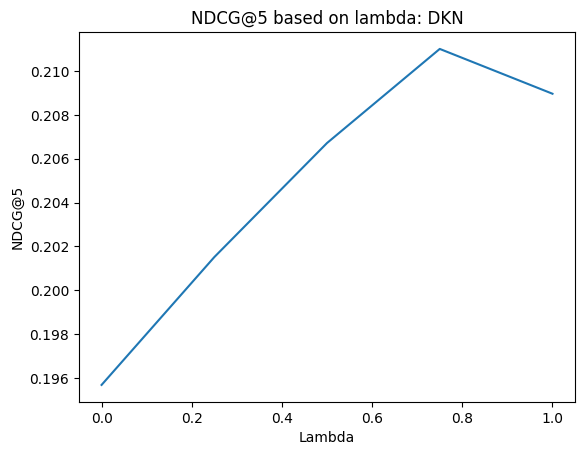

In [41]:
evaluation.graph_ndcg(ndcgs, lamdas, k, "DKN")

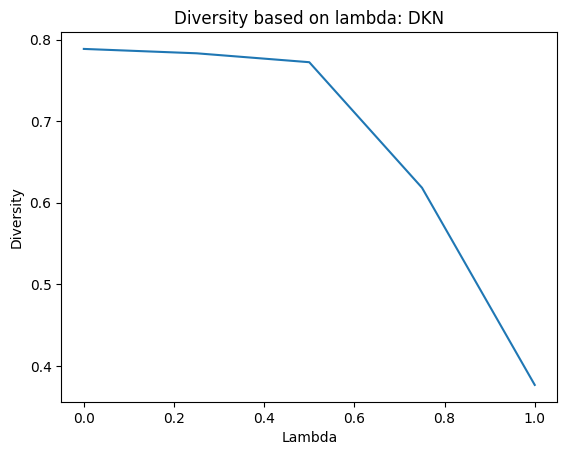

In [42]:
evaluation.graph_diversity(diversities, lamdas, "DKN")